In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats

%matplotlib inline

In [4]:
def offline_MIP(station, ax=False):

    data_dir = f"/cr/tempdata01/filip/SSDCalib/UubRates/{station}"
    rates = np.zeros(350)

    for file in os.listdir(data_dir):
        rates += np.loadtxt(f"{data_dir}/{file}")

    x_min, x_max = np.argmin(np.diff(rates)) + 10, 80
    mu = -np.log(rates[x_max] / rates[x_min]) / (x_max - x_min)

    background = lambda x: rates[x_min] * np.exp(-mu * (x-x_min))
    landau = lambda x, A, loc, scale: A * stats.moyal(loc, scale).pdf(x)
    residuals = rates[x_min:x_max] - background(range(x_min, x_max))

    popt, pcov = curve_fit(landau, range(x_min, x_max), residuals, [32, 10, 160])

    # Calculate uncertainty in mean from MC analysis
    means = []

    for i in range(1000):
        mean = np.random.normal(popt[1], np.sqrt(np.diag(pcov)[1]))
        std = np.random.normal(popt[2], np.sqrt(np.diag(pcov)[2]))
        means.append(stats.moyal(mean, std).mean())

    mean, sigma = np.mean(means), np.std(means)

    if ax:
        X = range(x_min, x_max)
        ax.set_title(station)
        ax.axvline(x_min, ls="--", c='gray')
        ax.axvline(x_max, ls="--", c='gray')
        ax.plot(range(x_min, x_max), residuals, label='data')
        ax.plot(X, landau(X, *popt), label='fit')
        ax.set_ylim(1e0) if station != "Peru" else None
        # ax.set_yscale("log") if station != "Peru" else None
        ax.axvline(mean, ls = ":", c="r")
        ax.axvspan(mean-sigma, mean+sigma, color="r", alpha=0.1)
        ax.legend()

    return mean, sigma

def online_MIP(station):

    data = np.loadtxt(f'/cr/tempdata01/filip/SSDCalib/OnlineCalib/OnlineThresholds/{station}.dat')

    if data.shape == (5,):
        return [[ data[0], data[2], 1 ]]
    else:
        online_rates = []
        for row in data:
            online_rates.append([ row[0], row[2], 1 ])
        
        return online_rates


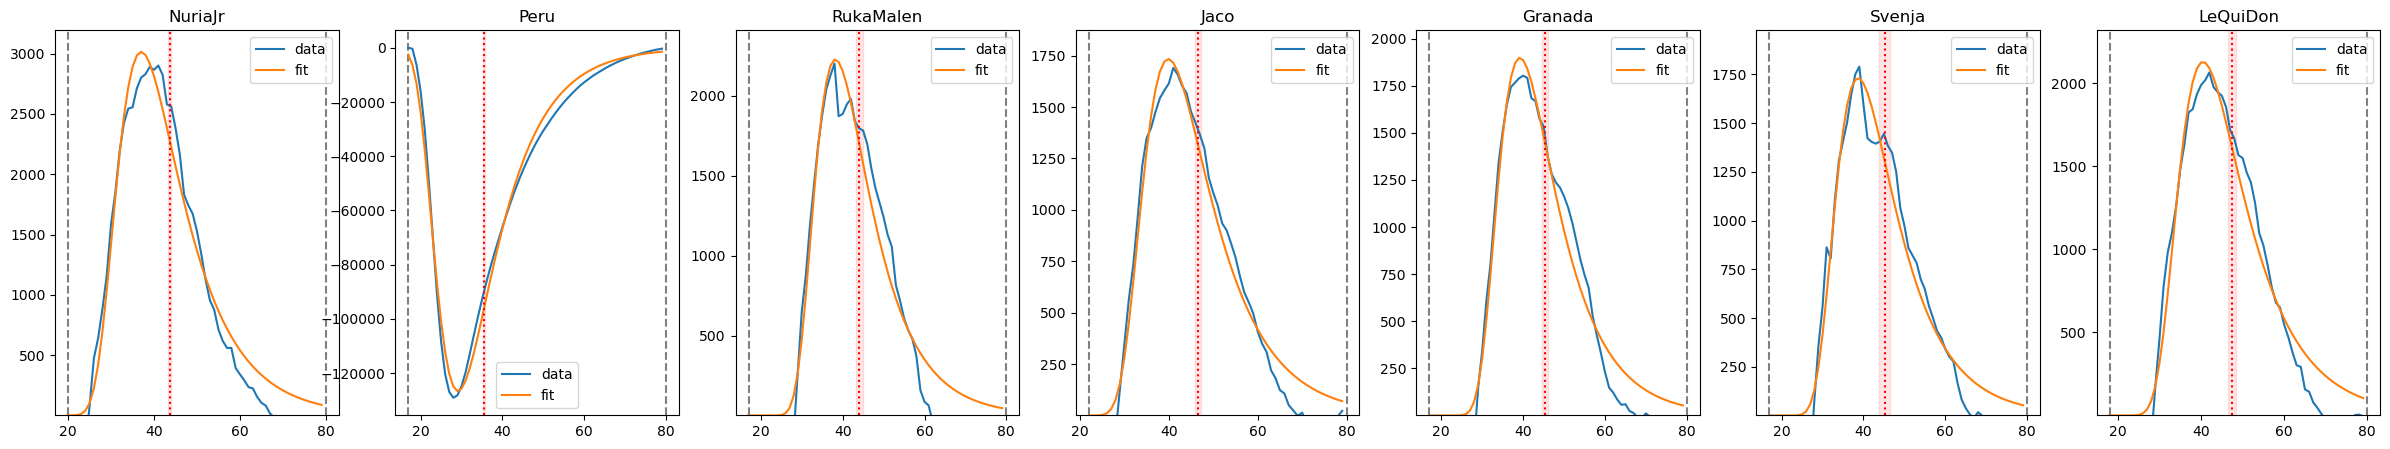

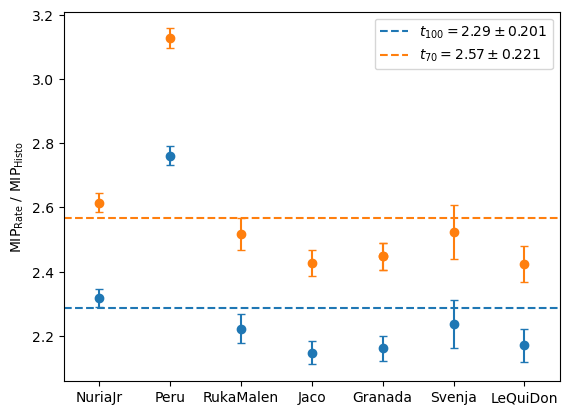

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(30,5))
stations = ["NuriaJr", "Peru", "RukaMalen", "Jaco", "Granada", "Svenja", "LeQuiDon"]
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
color, ratios = {}, {}

fig, ax0 = plt.subplots()

for i, (station, ax) in enumerate(zip(stations, axes)):
    OFFLINE_MIP = offline_MIP(station, ax)
    ONLINE_MIP = online_MIP(station)

    # if station == "Peru": continue

    for mip in ONLINE_MIP:
        
        ratio = mip[1] / OFFLINE_MIP[0]
        error = np.sqrt( (mip[2]/OFFLINE_MIP[0])**2 + (mip[1]/OFFLINE_MIP[0]**2 * OFFLINE_MIP[1])**2 )

        try:
            _ = color[mip[0]]
            ratios[mip[0]].append(ratio)
        except KeyError:
            color[mip[0]] = len(color)
            ratios[mip[0]] = [ratio]

        ax0.errorbar(i, ratio, yerr=error, color=cycle[color[mip[0]]], fmt='o', capsize=3)

for rate, c in color.items():
    ax0.axhline(np.mean(ratios[rate]), c=cycle[c], ls='--', label=f"$t_{{{int(rate)}}} = {np.mean(ratios[rate]):.2f} \pm {np.std(ratios[rate]):.3f}$")
    ax0.scatter([],[], color=cycle[c]) 

_ = ax0.set_ylabel(r"MIP$_\mathrm{Rate}$ / MIP$_\mathrm{Histo}$")
ax0.set_xticks(range(len(stations)), stations)
ax0.set_xlim(-0.5, i + 0.5)
ax0.legend()